In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 加载预训练模型
model = models.resnet50(pretrained=True)

# 移除最后的全连接层，获取全局平均池化后的特征
# 如果希望获取中间层特征可以修改这里
model = torch.nn.Sequential(*(list(model.children())[:-1]))  # 输出维度: [batch, 2048, 1, 1]
model = model.to(device).eval()  # 设置为评估模式

# 2. 定义图像预处理流程
preprocess = transforms.Compose([
    transforms.Resize(256),          # 缩放保持比例
    transforms.CenterCrop(224),      # 中心裁剪
    transforms.Grayscale(num_output_channels=3),  # 将灰度图复制为3通道
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet标准归一化参数
        std=[0.229, 0.224, 0.225]
    )
])

# 3. 特征提取函数
def extract_features(image_path):
    # 加载并预处理图像
    image = Image.open(image_path).convert('L')  # 强制转为灰度图
    input_tensor = preprocess(image)             # 应用预处理
    input_batch = input_tensor.unsqueeze(0)      # 添加batch维度 [1, 3, 224, 224]
    
    # 前向传播
    with torch.no_grad():
        features = model(input_batch.to(device))
    
    # 处理输出特征
    features = features.squeeze(-1).squeeze(-1)  # 去除最后两个维度 [1, 2048]
    return features.cpu().numpy().flatten()      # 转为numpy数组

# 4. 批量处理图像
image_dir = "/media/ubuntu/sda/data/trigger/NaturalImages_new_2"
all_features = {}

for img_name in os.listdir(image_dir):
    img_path = os.path.join(image_dir, img_name)
    if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        feature = extract_features(img_path)
        all_features[img_name] = feature
        print(f"Processed: {img_name}, Feature shape: {feature.shape}")



/home/ubuntu/.conda/envs/spike_sorting_jct/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/.conda/envs/spike_sorting_jct/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 26.8MB/s]


Processed: 108.jpg, Feature shape: (2048,)
Processed: 11.jpg, Feature shape: (2048,)
Processed: 24.jpg, Feature shape: (2048,)
Processed: 47.jpg, Feature shape: (2048,)
Processed: 48.jpg, Feature shape: (2048,)
Processed: 40.jpg, Feature shape: (2048,)
Processed: 110.jpg, Feature shape: (2048,)
Processed: 115.jpg, Feature shape: (2048,)
Processed: 41.jpg, Feature shape: (2048,)
Processed: 60.jpg, Feature shape: (2048,)
Processed: 46.jpg, Feature shape: (2048,)
Processed: 70.jpg, Feature shape: (2048,)
Processed: 30.jpg, Feature shape: (2048,)
Processed: 45.jpg, Feature shape: (2048,)
Processed: 91.jpg, Feature shape: (2048,)
Processed: 113.jpg, Feature shape: (2048,)
Processed: 101.jpg, Feature shape: (2048,)
Processed: 77.jpg, Feature shape: (2048,)
Processed: 107.jpg, Feature shape: (2048,)
Processed: 95.jpg, Feature shape: (2048,)
Processed: 88.jpg, Feature shape: (2048,)
Processed: 53.jpg, Feature shape: (2048,)
Processed: 26.jpg, Feature shape: (2048,)
Processed: 78.jpg, Feature s

In [ ]:
import pandas as pd
image_features = pd.DataFrame()

for key, item in all_features.items():
    image_features = pd.concat((image_features, pd.DataFrame(item, columns=[key])), axis=1)

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
principal_components = pca.fit_transform(image_features.T)

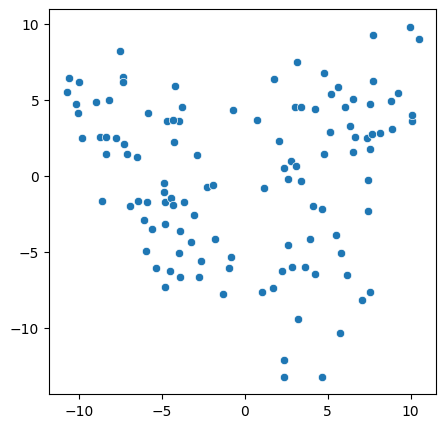

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,5))
sns.scatterplot(x = principal_components[:, 0],
                y = principal_components[:, 1])
plt.show()

In [19]:
import umap
image_reducer = umap.UMAP(n_components=3)
embedding = image_reducer.fit_transform(principal_components)

/home/ubuntu/.conda/envs/spike_sorting_jct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ubuntu/.conda/envs/spike_sorting_jct/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


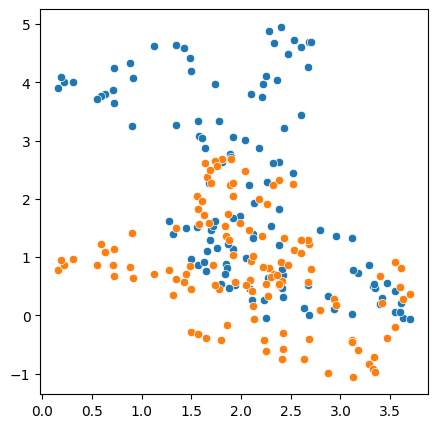

In [22]:
plt.figure(figsize=(5,5))
sns.scatterplot(x = embedding[:, 0],
                y = embedding[:, 1])
sns.scatterplot(x = embedding[:, 0],
                y = embedding[:, 2])
plt.show()

In [15]:
from sklearn.metrics.pairwise import cosine_similarity

features = np.array(list(all_features.values()))
similarity_matrix = cosine_similarity(features)

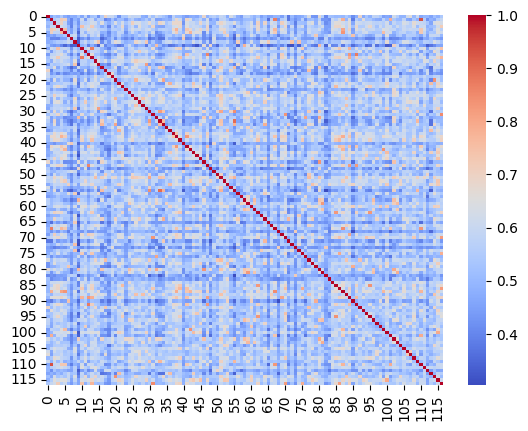

In [18]:
sns.heatmap(similarity_matrix, cmap="coolwarm")
plt.show()

In [23]:
image_features.to_csv("image_feature_ResNet50.csv")

In [3]:
import pandas as pd
image_feature = pd.read_csv("/media/ubuntu/sda/data/mouse6/output/06_visual_decoding/image_feature.csv").iloc[:, 1:]

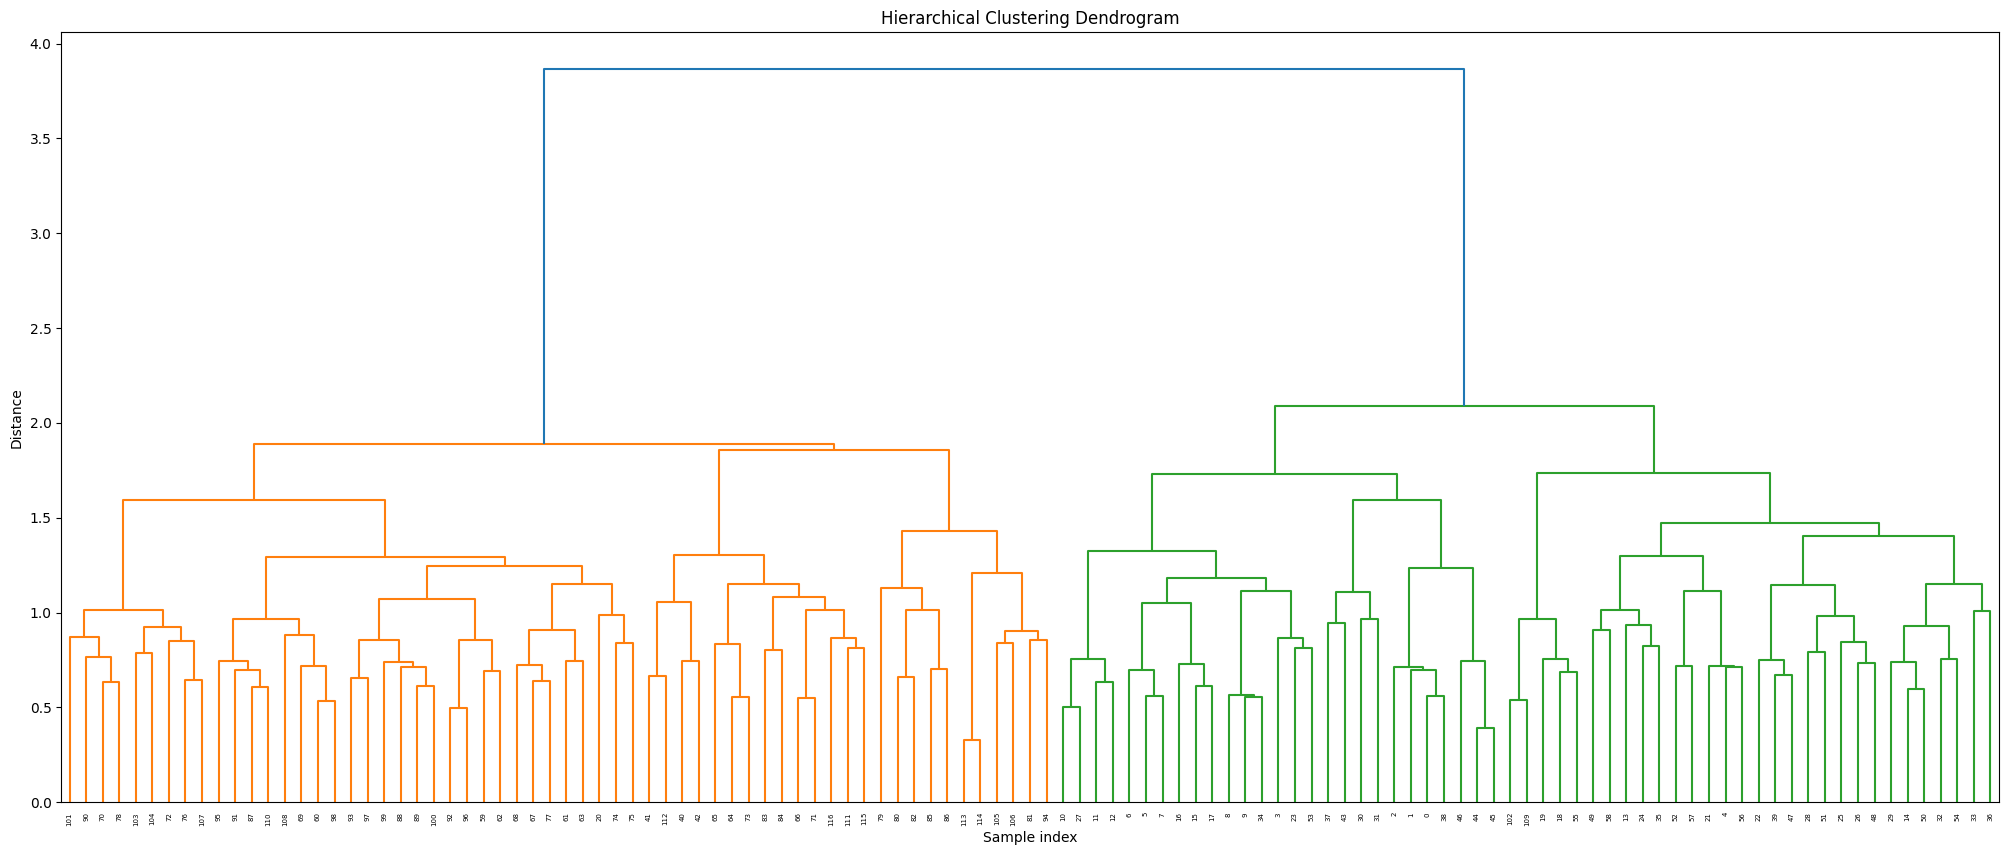

Cluster labels: [2 2 2 2 3 2 2 2 2 2 2 2 2 3 3 2 2 2 3 3 1 3 3 2 3 3 3 2 3 3 2 2 3 3 2 3 3
 2 2 3 1 1 1 2 2 2 2 3 3 3 3 3 3 2 3 3 3 3 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 3 1
 1 1 1 1 1 1]


In [7]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

Z = linkage(image_feature.to_numpy(), method='ward')

plt.figure(figsize=(25, 10))
dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

clusters = fcluster(Z, 2, criterion='distance')

print("Cluster labels:", clusters)

/home/ubuntu/.conda/envs/spike_sorting_jct/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


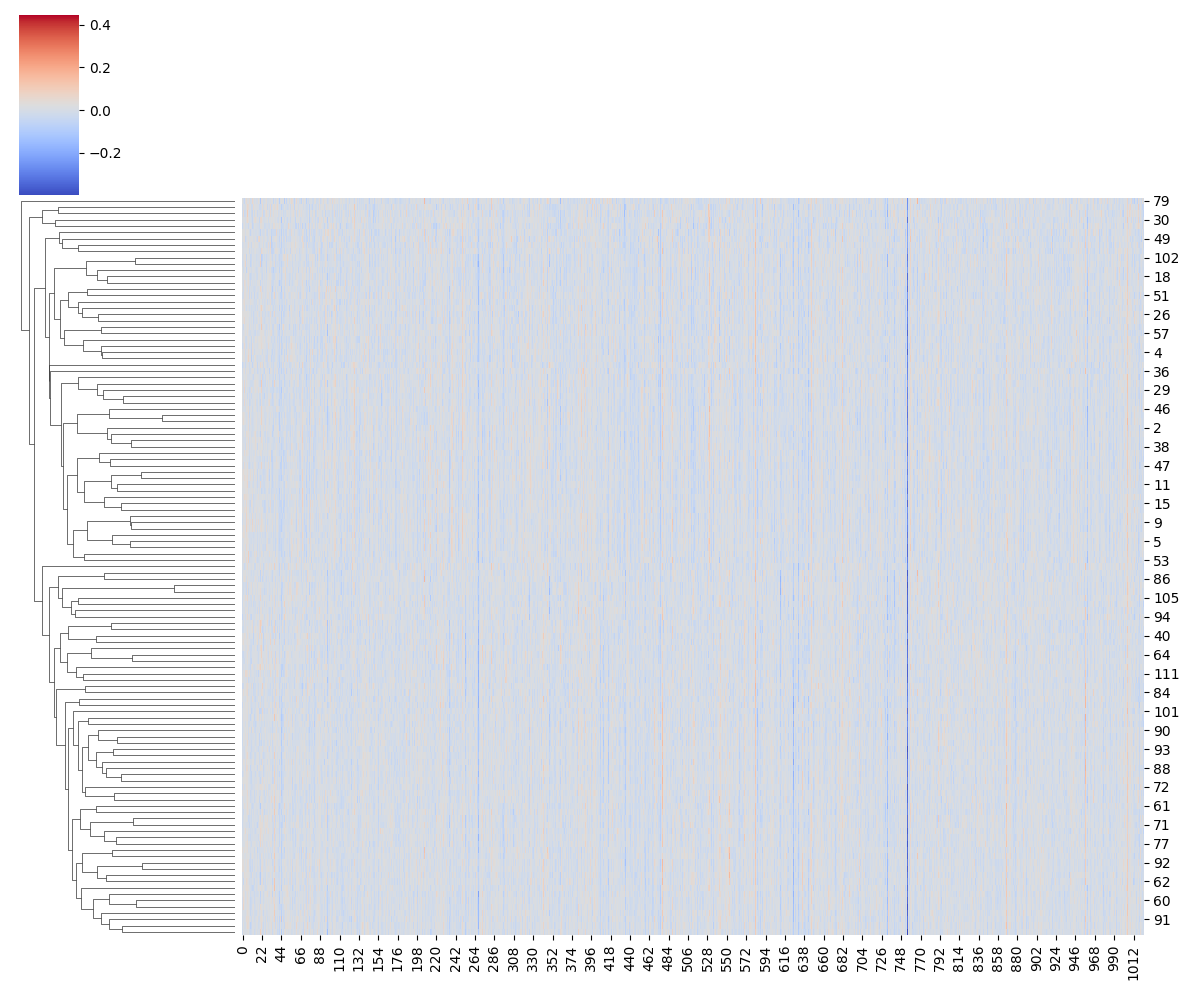

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.clustermap(image_feature.to_numpy(), cmap='coolwarm', figsize=(12, 10), col_cluster=False)

# 显示图形
plt.show()